## Visualizing statistical estimates and fits

This tutorial shows how to visualize interaction effects included in regression models such as:

$$
  y = \alpha + \beta * x + \gamma * z + \delta * x * z + \epsilon
$$

Mainly, we use interaction terms to take into account that the effect of the
independent variable $x$ on the outcome $y$ is contingent on the value of a third variable $z$.

Examples:

- the economic value of patents is contingent on the intellectual property regime of a country/set of countries
- the economic returns of schooling are contingent on the institutional and cultural environment of a country
- the social influence of a Soundcloud user's suggestions/reposts is contingent on followership
- the influence of job satisfaction on intent to quit is contingent on the size of the employer

## Setup

### Loading libraries

In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import statsmodels.api as sm        # sm & smf allow us to write regression in natural langauge
import statsmodels.formula.api as smf
import pandas as pd

### Viz options

In [2]:
rc('font',**{'family':'serif','serif':['Avant Garde']})
rc('text', usetex=False)

## Application

### Goal

The working hypothesis is that lower levels of job satisfaction ($x$) increases the chances of turnover, i.e., intent to quit ($y$).

On top of this, we think the negative relationship between $x$ and $y$ depends on the size of the employer. The intuition is that large employers have an internal labor market that allows individuals to change job positions (get a better fit with the task) without quitting the employment relation.

The goal is showing how the relationship between job satisfaction and intent to quit (as estimated via OLS) changes as firm size increases.



### Data simulation

We simulate multiple datasets involving the following variables:

- job satisfaction - the extent to which an employee is happy with his/her job (let's assume we have Likert scale data; legend: 1 = not at all, 5 = to a great extent)
- intent to quit - the extent to which an employee considers the possibility to quit the current job (let's assume we have Likert scale data; legend: 1 = not at all, 5 = to a great extent)
- age (in years)
- organizational tenure (years spent working for the employer)
- Let's assume that all variables have been transformed into z-scores.

Each dataset we simulate reflect the following cohorts of employers:

- micro firms: 1 - 5 employees
- small firms: 6 - 25 employees
- medium firms: 26 - 100 employees
- large firms: 100 - 500 employees
- very large firms: 500 +

Logic of interaction term --> (job satisfaction * size of company)
- the bigger the company, the weaker the relationship between job satisfaction and intend to quit because you know there are some opportunities coming from the internal labour market

In [3]:
# sample size
num_samples = 1000

# variables' mean 
mu = np.repeat(0, 4)

# names
names = ['job_sat', 'int_qui', 'age', 'org_tnr']  
# org_tnr = organizational tenure = the time you spend wokring in the firm

#### Micro firms

In [4]:
# the desired covariance matrix.
r = np.array([
        [  1.00, -0.40, -0.03,  0.11],
        [ -0.40,  1.00, -0.05, -0.09],
        [ -0.03, -0.05,  1.00,  0.05],
        [  0.11, -0.09,  0.05,  1.00]
    ])

### row 1 col 2 = covariance of job statisfaction & intend to quit = -0.4
# the higher the job satisfaction, the lower the probability of intend to quit
### row 1 col 4 = job_sta & org_tnr = 0.11
# the longer you stay working in a firm, the more statisfy a person is with the job

# generate the random samples.
df_1_5 = pd.DataFrame(np.random.multivariate_normal(mu, r, size=num_samples),
                      columns=names)

# np.random.multivariate_normal --> allow us to stimulate the data set containing several columns starting from a
# covariance matrix.

# expand
df_1_5.loc[:, 'cohort'] = 'micro'
# randomly assign a number ranging from 1 to 5 for number of employees in the firm 
df_1_5.loc[:, 'firm_size'] = np.random.randint(low=1, high=5, size=num_samples)
# firm size can be used as the moderate or z

In [5]:
df_1_5.head()

,job_sat,int_qui,age,org_tnr,cohort,firm_size
0,-0.189031,1.685191,-1.077941,-0.406549,micro,4
1,0.143127,-1.697969,-0.228274,0.323362,micro,1
2,0.958013,0.137688,0.753199,1.018954,micro,2
3,-0.345289,0.315928,-0.306892,-1.589406,micro,3
4,-0.815181,0.136223,0.507321,0.406389,micro,2


#### Small firms

In [6]:
# the desired covariance matrix.
r = np.array([
        [  1.00, -0.30, -0.03,  0.11],
        [ -0.30,  1.00, -0.05, -0.09],
        [ -0.03, -0.05,  1.00,  0.05],
        [  0.11, -0.09,  0.05,  1.00]
    ])

# only value that has changed is (job_sta * int_quit) --> -0.4 to -0.3
# weaker covariance between the 2

# generate the random samples.
df_6_25 = pd.DataFrame(np.random.multivariate_normal(mu, r, size=num_samples),
                       columns=names)

# expand
df_6_25.loc[:, 'cohort'] = 'large'
df_6_25.loc[:, 'firm_size'] = np.random.randint(low=6,
                                                high=25,
                                                size=num_samples)

In [7]:
df_6_25.head()

,job_sat,int_qui,age,org_tnr,cohort,firm_size
0,1.661578,-0.391762,1.507934,1.427317,large,23
1,1.047328,0.928989,-1.840482,0.140753,large,14
2,0.454581,-0.150350,0.543869,0.738162,large,8
3,0.415116,0.396289,0.300008,-0.438544,large,9
4,-1.096910,0.514137,-0.207910,-0.837727,large,9


#### Medium firms

In [8]:
# the desired covariance matrix.
r = np.array([
        [  1.00, -0.25, -0.03,  0.11],
        [ -0.25,  1.00, -0.05, -0.09],
        [ -0.03, -0.05,  1.00,  0.05],
        [  0.11, -0.09,  0.05,  1.00]
    ])

# only value that has changed is (job_sta * int_quit) 

# generate the random samples.
df_26_100 = pd.DataFrame(np.random.multivariate_normal(mu, r, size=num_samples),
                         columns=names)

# expand
df_26_100.loc[:, 'cohort'] = 'medium'
df_26_100.loc[:, 'firm_size'] = np.random.randint(low=26,
                                                  high=100,
                                                  size=num_samples)

#### Large firms

In [9]:
# the desired covariance matrix.
r = np.array([
        [  1.00, -0.20, -0.03,  0.11],
        [ -0.20,  1.00, -0.05, -0.09],
        [ -0.03, -0.05,  1.00,  0.05],
        [  0.11, -0.09,  0.05,  1.00]
    ])

# only value that has changed is (job_sta * int_quit) 

# generate the random samples.
df_101_500 = pd.DataFrame(np.random.multivariate_normal(mu, r, size=num_samples),
                          columns=names)

# expand
df_101_500.loc[:, 'cohort'] = 'large'
df_101_500.loc[:, 'firm_size'] = np.random.randint(low=101, high=500,
                                                size=num_samples)

#### Very large firms

In [10]:
# the desired covariance matrix.
r = np.array([
        [  1.00, -0.15, -0.03,  0.11],
        [ -0.15,  1.00, -0.05, -0.09],
        [ -0.03, -0.05,  1.00,  0.05],
        [  0.11, -0.09,  0.05,  1.00]
    ])

# covariance for (job_sta * int_quit) is even weaker

# generate the random samples.
df_501_ = pd.DataFrame(np.random.multivariate_normal(mu, r, size=num_samples),
                       columns=names)

# expand
df_501_.loc[:, 'cohort'] = 'very large'
df_501_.loc[:, 'firm_size'] = np.random.randint(low=501, high=2000,
                                                size=num_samples)

### Data preparation

In [11]:
# concatenate all the df into 1 single df by rows (axis=0)
df = pd.concat([df_1_5, df_6_25, df_26_100, df_101_500, df_501_],
               axis=0)
df.info()

df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   job_sat    5000 non-null   float64
 1   int_qui    5000 non-null   float64
 2   age        5000 non-null   float64
 3   org_tnr    5000 non-null   float64
 4   cohort     5000 non-null   object 
 5   firm_size  5000 non-null   int32  
dtypes: float64(4), int32(1), object(1)
memory usage: 253.9+ KB


,job_sat,int_qui,age,org_tnr,cohort,firm_size
0,-0.189031,1.685191,-1.077941,-0.406549,micro,4
1,0.143127,-1.697969,-0.228274,0.323362,micro,1
2,0.958013,0.137688,0.753199,1.018954,micro,2
3,-0.345289,0.315928,-0.306892,-1.589406,micro,3
4,-0.815181,0.136223,0.507321,0.406389,micro,2


## Regression analysis

Aim:
- produce a regression analysis linking x to y
- also the moderating effect of the variable z
- y = intend to quit
- x = job statisfaction
- z = size of firm

Choose 1 to do:
- estimating separate regression models by the cohort of firms, then compare the 5 regression slopes (no need interaction terms in this case)
- building a df including the interaction effect, then will only have 1 regression slope

In [21]:
# create new variable
df['JobSat_FirmSize'] = df.job_sat * df.firm_size

model_interaction = smf.ols('int_qui ~ job_sat + firm_size + JobSat_FirmSize', data = df).fit()
print(model_interaction.summary())

                            OLS Regression Results                            
Dep. Variable:                int_qui   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     120.9
Date:                Thu, 05 Nov 2020   Prob (F-statistic):           1.39e-75
Time:                        16:06:45   Log-Likelihood:                -6813.8
No. Observations:                5000   AIC:                         1.364e+04
Df Residuals:                    4996   BIC:                         1.366e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.0034      0.016     

## Visualisation

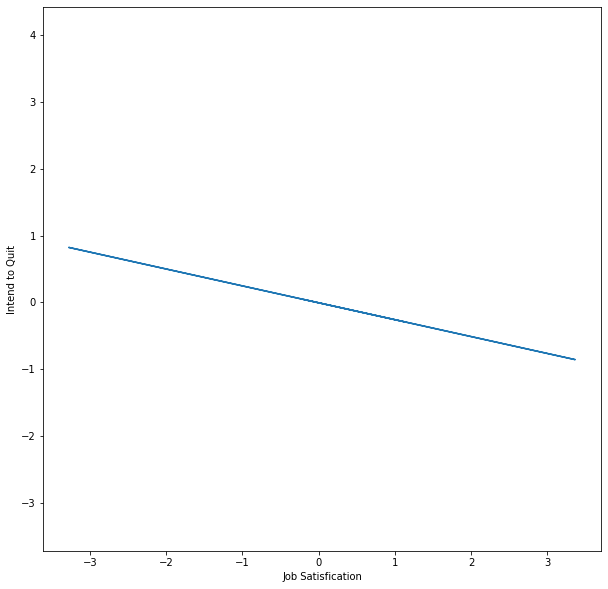

In [30]:
# create the figure
fig = plt.figure(figsize = (10,10))

# populate figure with a plot
ax = fig.add_subplot(1 , 1 , 1)

# y and x variables 
y = df.loc[:, "int_qui"]
x1 = df.loc[:, "job_sat"]   # without interaction term


# plotting data points
chart = ax.scatter(x1,y, alpha = 0)  # without interaction term

# axes label
ax.set_ylabel('Intend to Quit')
ax.set_xlabel('Job Satisfication')

# add line of best fit for regression with no interaction term
OLS = smf.ols('int_qui ~ job_sat', data = df).fit()
model = OLS.fittedvalues
ax.plot(x1, model)

# plot figure
plt.show()